In [ ]:
!pwd

In [ ]:
!pip install tqdm  -i https://pypi.tuna.tsinghua.edu.cn/simple


In [ ]:
# 检查 mmsegmentation
import mmseg
from mmseg.utils import register_all_modules
from mmseg.apis import inference_model, init_model
print('mmsegmentation版本', mmseg.__version__)

In [ ]:
import numpy as np
from PIL import Image

import os.path as osp
from tqdm import tqdm

import mmcv
import mmengine
import matplotlib.pyplot as plt
%matplotlib inline

In [ ]:
import os

# 创建 checkpoint 文件夹，用于存放预训练模型权重文件
os.mkdir('checkpoint')

# 创建 outputs 文件夹，用于存放预测结果
os.mkdir('outputs')

# 创建 data 文件夹，用于存放图片和视频素材
os.mkdir('data')

In [ ]:
# 伦敦街景图片
!wget https://zihao-openmmlab.obs.cn-east-3.myhuaweicloud.com/20220713-mmdetection/images/street_uk.jpeg -P data

# 上海驾车街景视频，视频来源：https://www.youtube.com/watch?v=ll8TgCZ0plk
!wget https://zihao-download.obs.cn-east-3.myhuaweicloud.com/detectron2/traffic.mp4 -P data

# 街拍视频，2022年3月30日
!wget https://zihao-openmmlab.obs.cn-east-3.myhuaweicloud.com/20220713-mmdetection/images/street_20220330_174028.mp4 -P data


In [ ]:
!wget https://zihao-openmmlab.obs.cn-east-3.myhuaweicloud.com/20230130-mmseg/dataset/iccv09Data.zip


In [ ]:
# 解压
!unzip iccv09Data.zip >> /dev/null

In [ ]:
# 删除压缩包
!rm -rf iccv09Data.zip

In [ ]:
Image.open('iccv09Data/images/6000124.jpg')

In [ ]:
Image.open('iccv09Data/labels/6000124.png')

In [1]:
# 数据集图片和标注路径
data_root = 'iccv09Data'
img_dir = 'images'
ann_dir = 'labels'

# 类别和对应的颜色
classes = ('background','pathology')
palette = [[53, 125, 34], [0, 11, 123]]
#classes = ('sky', 'tree', 'road', 'grass', 'water', 'bldg', 'mntn', 'fg obj')
#palette = [[128, 128, 128], [129, 127, 38], [120, 69, 125], [53, 125, 34], 
#           [0, 11, 123], [118, 20, 12], [122, 81, 25], [241, 134, 51]]
 

In [3]:
import matplotlib.patches as mpatches
img = Image.open('iccv09Data/labels/6000124.png')
plt.figure(figsize=(8, 6))
im = plt.imshow(np.array(img.convert('RGB')))

# 图例小块
patches = [mpatches.Patch(color=np.array(palette[i])/255., label=classes[i]) for i in range(8)]
# 图例
plt.legend(handles=patches, bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0., fontsize='large')
plt.show()

NameError: name 'Image' is not defined

In [2]:
from mmseg.registry import DATASETS
from mmseg.datasets import BaseSegDataset

@DATASETS.register_module()
class StanfordBackgroundDataset(BaseSegDataset):
  METAINFO = dict(classes = classes, palette = palette)
  def __init__(self, **kwargs):
    super().__init__(img_suffix='.png', seg_map_suffix='.png', **kwargs)

/home/shitianlei/anaconda3/envs/mmlab/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
# 下载 config 文件 和 预训练模型checkpoint权重文件
!mim download mmsegmentation --config pspnet_r50-d8_4xb2-40k_cityscapes-512x1024 --dest .

processing pspnet_r50-d8_4xb2-40k_cityscapes-512x1024...
pspnet_r50-d8_512x1024_40k_cityscapes_20200605_003338-2966598c.pth exists in /data1/shitianlei/openmmlab/mmsegmentation
Successfully dumped pspnet_r50-d8_4xb2-40k_cityscapes-512x1024.py to /data1/shitianlei/openmmlab/mmsegmentation


In [5]:
from mmengine import Config
cfg = Config.fromfile('configs/pspnet/pspnet_r50-d8_4xb2-40k_cityscapes-512x1024.py')

In [7]:
img_dir = 'images'
ann_dir = 'masks'
cfg.norm_cfg = dict(type='BN', requires_grad=True) # 只使用GPU时，BN取代SyncBN
cfg.crop_size = (256, 256)
cfg.model.data_preprocessor.size = cfg.crop_size
cfg.model.backbone.norm_cfg = cfg.norm_cfg
cfg.model.decode_head.norm_cfg = cfg.norm_cfg
cfg.model.auxiliary_head.norm_cfg = cfg.norm_cfg
# modify num classes of the model in decode/auxiliary head
cfg.model.decode_head.num_classes = 8
cfg.model.auxiliary_head.num_classes = 8

# 修改数据集的 type 和 root
cfg.dataset_type = 'StanfordBackgroundDataset'
cfg.data_root = '/data1/shitianlei/openmmlab/mmsegmentation/data/Glomeruli/'

cfg.train_dataloader.batch_size = 8

cfg.train_pipeline = [
    dict(type='LoadImageFromFile'),
    dict(type='LoadAnnotations'),
    dict(type='RandomResize', scale=(320, 240), ratio_range=(0.5, 2.0), keep_ratio=True),
    dict(type='RandomCrop', crop_size=cfg.crop_size, cat_max_ratio=0.75),
    dict(type='RandomFlip', prob=0.5),
    dict(type='PackSegInputs')
]

cfg.test_pipeline = [
    dict(type='LoadImageFromFile'),
    dict(type='Resize', scale=(320, 240), keep_ratio=True),
    # add loading annotation after ``Resize`` because ground truth
    # does not need to do resize data transform
    dict(type='LoadAnnotations'),
    dict(type='PackSegInputs')
]


cfg.train_dataloader.dataset.type = cfg.dataset_type
cfg.train_dataloader.dataset.data_root = cfg.data_root
cfg.train_dataloader.dataset.data_prefix = dict(img_path=img_dir, seg_map_path=ann_dir)
cfg.train_dataloader.dataset.pipeline = cfg.train_pipeline
cfg.train_dataloader.dataset.ann_file = 'splits/train.txt'

cfg.val_dataloader.dataset.type = cfg.dataset_type
cfg.val_dataloader.dataset.data_root = cfg.data_root
cfg.val_dataloader.dataset.data_prefix = dict(img_path=img_dir, seg_map_path=ann_dir)
cfg.val_dataloader.dataset.pipeline = cfg.test_pipeline
cfg.val_dataloader.dataset.ann_file = 'splits/val.txt'

cfg.test_dataloader = cfg.val_dataloader


# 载入预训练模型权重
cfg.load_from = 'checkpoint/pspnet_r50-d8_512x1024_40k_cityscapes_20200605_003338-2966598c.pth'

# 工作目录
cfg.work_dir = './work_dirs/glomeruli_pspnet'

# 训练迭代次数
cfg.train_cfg.max_iters = 800
# 评估模型间隔
cfg.train_cfg.val_interval = 400
# 日志记录间隔
cfg.default_hooks.logger.interval = 100
# 模型权重保存间隔
cfg.default_hooks.checkpoint.interval = 400

# 随机数种子
cfg['randomness'] = dict(seed=0)

In [8]:
print(cfg.pretty_text)

norm_cfg = dict(type='BN', requires_grad=True)
data_preprocessor = dict(
    type='SegDataPreProcessor',
    mean=[123.675, 116.28, 103.53],
    std=[58.395, 57.12, 57.375],
    bgr_to_rgb=True,
    pad_val=0,
    seg_pad_val=255,
    size=(512, 1024))
model = dict(
    type='EncoderDecoder',
    data_preprocessor=dict(
        type='SegDataPreProcessor',
        mean=[123.675, 116.28, 103.53],
        std=[58.395, 57.12, 57.375],
        bgr_to_rgb=True,
        pad_val=0,
        seg_pad_val=255,
        size=(256, 256)),
    pretrained='open-mmlab://resnet50_v1c',
    backbone=dict(
        type='ResNetV1c',
        depth=50,
        num_stages=4,
        out_indices=(0, 1, 2, 3),
        dilations=(1, 1, 2, 4),
        strides=(1, 2, 1, 1),
        norm_cfg=dict(type='BN', requires_grad=True),
        norm_eval=False,
        style='pytorch',
        contract_dilation=True),
    decode_head=dict(
        type='PSPHead',
        in_channels=2048,
        in_index=3,
        channels

In [9]:
from mmengine.runner import Runner
from mmseg.utils import register_all_modules

# register all modules in mmseg into the registries
# do not init the default scope here because it will be init in the runner
register_all_modules(init_default_scope=False)
runner = Runner.from_cfg(cfg)

02/13 16:44:27 - mmengine - INFO - 
------------------------------------------------------------
System environment:
    sys.platform: linux
    Python: 3.8.13 (default, Mar 28 2022, 11:38:47) [GCC 7.5.0]
    CUDA available: True
    numpy_random_seed: 0
    GPU 0,1,2,3: NVIDIA GeForce RTX 3090
    CUDA_HOME: /usr/local/cuda
    NVCC: Cuda compilation tools, release 11.6, V11.6.112
    GCC: gcc (Ubuntu 9.4.0-1ubuntu1~20.04.1) 9.4.0
    PyTorch: 1.12.1+cu116
    PyTorch compiling details: PyTorch built with:
  - GCC 9.3
  - C++ Version: 201402
  - Intel(R) Math Kernel Library Version 2020.0.0 Product Build 20191122 for Intel(R) 64 architecture applications
  - Intel(R) MKL-DNN v2.6.0 (Git Hash 52b5f107dd9cf10910aaa19cb47f3abf9b349815)
  - OpenMP 201511 (a.k.a. OpenMP 4.5)
  - LAPACK is enabled (usually provided by MKL)
  - NNPACK is enabled
  - CPU capability usage: AVX2
  - CUDA Runtime 11.6
  - NVCC architecture flags: -gencode;arch=compute_37,code=sm_37;-gencode;arch=compute_50,code=

/data1/shitianlei/openmmlab/mmsegmentation/mmseg/models/backbones/resnet.py:431: UserWarning: DeprecationWarning: pretrained is a deprecated, please use "init_cfg" instead
  warnings.warn('DeprecationWarning: pretrained is a deprecated, '
/data1/shitianlei/openmmlab/mmsegmentation/mmseg/models/builder.py:36: UserWarning: ``build_loss`` would be deprecated soon, please use ``mmseg.registry.MODELS.build()`` 
  warnings.warn('``build_loss`` would be deprecated soon, please use '
/data1/shitianlei/openmmlab/mmsegmentation/mmseg/models/losses/cross_entropy_loss.py:235: UserWarning: Default ``avg_non_ignore`` is False, if you would like to ignore the certain label and average loss over non-ignore labels, which is the same with PyTorch official cross_entropy, set ``avg_non_ignore=True``.
  warnings.warn(


02/13 16:44:30 - mmengine - INFO - Distributed training is not used, all SyncBatchNorm (SyncBN) layers in the model will be automatically reverted to BatchNormXd layers if they are used.
02/13 16:44:30 - mmengine - WARNING - The "hook" registry in mmseg did not set import location. Fallback to call `mmseg.utils.register_all_modules` instead.
02/13 16:44:30 - mmengine - INFO - Hooks will be executed in the following order:
before_run:
(VERY_HIGH   ) RuntimeInfoHook                    
(BELOW_NORMAL) LoggerHook                         
 -------------------- 
before_train:
(VERY_HIGH   ) RuntimeInfoHook                    
(NORMAL      ) IterTimerHook                      
(VERY_LOW    ) CheckpointHook                     
 -------------------- 
before_train_epoch:
(VERY_HIGH   ) RuntimeInfoHook                    
(NORMAL      ) IterTimerHook                      
(NORMAL      ) DistSamplerSeedHook                
 -------------------- 
before_train_iter:
(VERY_HIGH   ) RuntimeInfoHook  

/data1/shitianlei/openmmlab/mmsegmentation/mmseg/engine/hooks/visualization_hook.py:61: UserWarning: The draw is False, it means that the hook for visualization will not take effect. The results will NOT be visualized or stored.
  warnings.warn('The draw is False, it means that the '


In [12]:
runner.train()

02/13 16:49:04 - mmengine - INFO - Checkpoints will be saved to /data1/shitianlei/openmmlab/mmsegmentation/work_dirs/glomeruli_pspnet.


/home/shitianlei/anaconda3/envs/mmlab/lib/python3.8/site-packages/mmengine/model/base_module.py:124: UserWarning: init_weights of EncoderDecoder has been called more than once.
  warnings.warn(f'init_weights of {self.__class__.__name__} has '


02/13 16:49:09 - mmengine - INFO - Iter(train) [500/800]  lr: 9.8888e-03  eta: 0:18:47  time: 0.1837  data_time: 0.0489  memory: 3774  loss: 0.0284  decode.loss_ce: 0.0187  decode.acc_seg: 99.5813  aux.loss_ce: 0.0097  aux.acc_seg: 99.4173
02/13 16:49:45 - mmengine - INFO - Iter(train) [600/800]  lr: 9.8665e-03  eta: 0:03:47  time: 0.9287  data_time: 0.7916  memory: 3774  loss: 0.0368  decode.loss_ce: 0.0242  decode.acc_seg: 99.9936  aux.loss_ce: 0.0127  aux.acc_seg: 99.9931
02/13 16:50:06 - mmengine - INFO - Iter(train) [700/800]  lr: 9.8442e-03  eta: 0:01:13  time: 0.1884  data_time: 0.0531  memory: 3774  loss: 0.0245  decode.loss_ce: 0.0166  decode.acc_seg: 98.5157  aux.loss_ce: 0.0080  aux.acc_seg: 98.5528
02/13 16:50:25 - mmengine - INFO - Iter(train) [800/800]  lr: 9.8218e-03  eta: 0:00:00  time: 0.1910  data_time: 0.0543  memory: 3774  loss: 0.0135  decode.loss_ce: 0.0085  decode.acc_seg: 99.9128  aux.loss_ce: 0.0050  aux.acc_seg: 99.8942
02/13 16:50:25 - mmengine - INFO - Savin

EncoderDecoder(
  (data_preprocessor): SegDataPreProcessor()
  (backbone): ResNetV1c(
    (stem): Sequential(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (4): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): ReLU(inplace=True)
      (6): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (7): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (8): ReLU(inplace=True)
    )
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): ResLayer(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-0

In [13]:
from mmseg.apis import init_model, inference_model, show_result_pyplot

In [14]:
# 初始化模型
checkpoint_path = '/data1/shitianlei/openmmlab/mmsegmentation/work_dirs/glomeruli_pspnet/iter_800.pth'
model = init_model(cfg, checkpoint_path, 'cuda:0')

/data1/shitianlei/openmmlab/mmsegmentation/mmseg/models/builder.py:36: UserWarning: ``build_loss`` would be deprecated soon, please use ``mmseg.registry.MODELS.build()`` 
  warnings.warn('``build_loss`` would be deprecated soon, please use '
/data1/shitianlei/openmmlab/mmsegmentation/mmseg/models/losses/cross_entropy_loss.py:235: UserWarning: Default ``avg_non_ignore`` is False, if you would like to ignore the certain label and average loss over non-ignore labels, which is the same with PyTorch official cross_entropy, set ``avg_non_ignore=True``.
  warnings.warn(


Loads checkpoint by local backend from path: /data1/shitianlei/openmmlab/mmsegmentation/work_dirs/glomeruli_pspnet/iter_800.pth


In [26]:

import numpy as np
from PIL import Image

import os.path as osp
from tqdm import tqdm

import mmcv
import mmengine
import matplotlib.pyplot as plt
%matplotlib inline

In [28]:
# 载入测试图像
img = mmcv.imread('/data1/shitianlei/openmmlab/mmsegmentation/data/Glomeruli/images/VUHSK_2072_61.png')
# img = mmcv.imread('iccv09Data/images/6000295.jpg')

In [29]:
# 预测
result = inference_model(model, img)

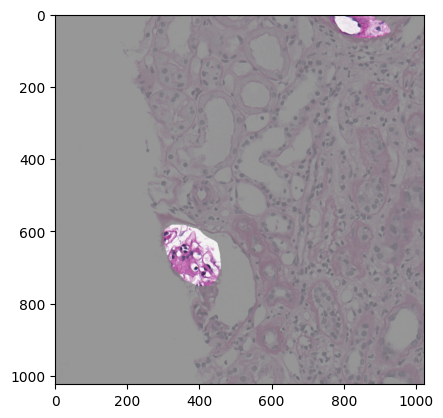

In [30]:
# 可视化预测结果
visualization = show_result_pyplot(model, img, result, opacity=0.8, title='MMSeg', out_file='outputs/C.jpg')
plt.imshow(mmcv.bgr2rgb(visualization))
plt.show()

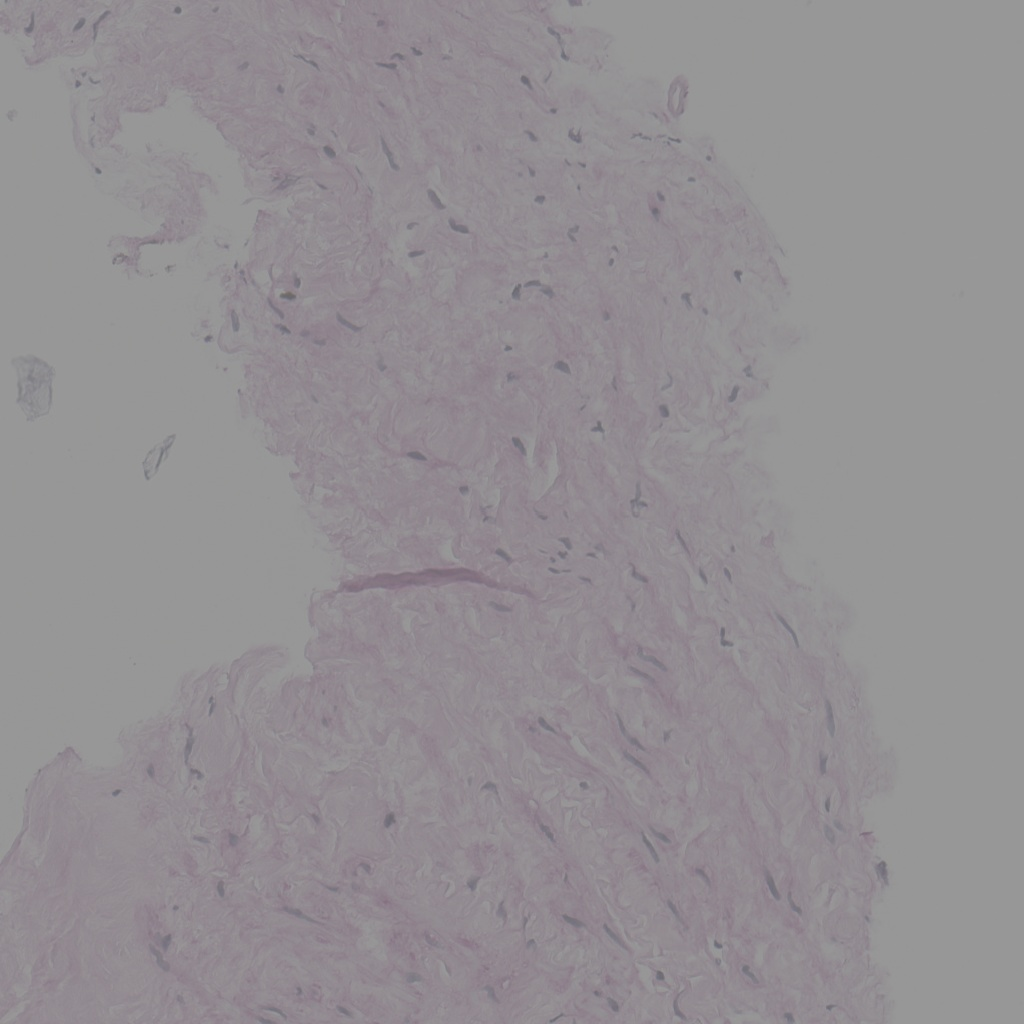

In [27]:
Image.open('outputs/C.jpg')